In [112]:
%matplotlib inline

import io, os, sys, types, datetime, pickle, warnings

warnings.filterwarnings('ignore')

import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

import numpy as np
from numpy.linalg import eig, inv

import math

from scipy import interpolate, spatial, stats

import seaborn as sns

import skimage.io as skiIo
from skimage import exposure, img_as_float, filters, morphology, transform

from sklearn import linear_model
from sklearn import metrics

In [113]:
""" ============== path settings =============="""

' ============== path settings =============='

In [114]:
global isMac
isMac = True

if(isMac):
#     dataPrefix = '/Users/lily/Lily/Academic/AW_Lab/data/fate_switching_gal80/Summary/Data'
    dataPrefix = '/Volumes/Project/2015_07_Neural_Superposition/Projects/Weiyue/Data_Analysis/Fate_Switching_experiments/Data_Gal80'
    imageDataPrefix = '/Users/lily/Lily/Academic/AW_Lab/data/fate_switching_gal80/Summary/Data'
    figOutPrefix = '/Users/lily/Lily/Academic/AW_Lab/data/fate_switching_gal80/Summary/FigureOutput1'
    dataOutPrefix = '/Users/lily/Lily/Academic/AW_Lab/data/fate_switching_gal80/Summary/DataOutput1'
    module_path = '/Volumes/Project/2015_07_Neural_Superposition/Projects/Weiyue/Code/python_cluster/helper_functions'
else:
#     sys.path.insert(0, 'Z:\\lab\\Projects\\NSP\\NSP_Code\\python\\Quantification_fromPositionOnly\\Functions')
    dataPrefix = 'W:\\2015_07_Neural_Superposition\\Projects\\Weiyue\\Data_Analysis\\Fate_Switching_experiments\\Data_Gal80'
    imageDataPrefix = dataPrefix
    figOutPrefix = 'W:\\2015_07_Neural_Superposition\\Projects\\Weiyue\\Data_Analysis\\Fate_Switching_experiments\\Output_Gal80\\DataOutput_temp'
    dataOutPrefix = 'W:\\2015_07_Neural_Superposition\\Projects\\Weiyue\\Data_Analysis\\Fate_Switching_experiments\\Output_Gal80\\FigureOutput_temp'
    module_path = 'W:\\2015_07_Neural_Superposition\\Projects\\Weiyue\\Code\\python_cluster\\helper_functions'
#     dataPrefix = 'D:\\WEIYUE\\Data_Analysis\\Summary\\Data'
#     figOutPrefix = ''
#     dataOutPrefix = 'D:\\WEIYUE\\Data_Analysis\\Summary\\DataOutput'

In [115]:
### import custom functions
if module_path not in sys.path:
    sys.path.append(module_path)
import Data_quantification_function_helper as my_help
import Data_quantification_function_intensity_calculation1 as my_int
import Data_quantification_function_parse_bundle1 as my_pb
import Data_quantification_function_plotting as my_plot


In [147]:
### file parameters
# file folders
imageFolder = 'Images_2c'
# imageFolder = 'Images'

ROIFolder = 'ROIs'
summaryFolder = 'Annotations'
dataFolder = 'DataOutput'



# file name
summaryName = 'Fz_Gal80_s26r1_summary.csv'

In [148]:
summaryName

'Fz_Gal80_s26r1_summary.csv'

In [149]:
### analysis parameters
radiusExpanseRatio = [2.5, 3]
# num_angleSection = 20
# num_outsideAngle = 20
num_angleSection = 10 # must be even number
num_outsideAngle = 10
num_Xsection = 10
z_offset = 5

analysisParams_general = (num_angleSection, num_outsideAngle, num_Xsection, z_offset, radiusExpanseRatio)


In [150]:
targetIndexMatch = {0:0, 1:2, 2:3, 3:4, 4:5, 5:7}
targetIndexMatch_rev = {0:0, 2:1, 3:2, 4:3, 5:4, 7:5}
ColorCode = {1:'#00FFFF', 2:'#1FF509', 3: '#FF0000', 4: '#CFCF1C', 5: '#FF00FF', 6: '#FFAE01', 7:'#983535', 0:'#FFFFFF'}
channel_mapping = {'RFP':0, 'GFP':1, 'R3_1':2, 'R4_1':3, 'R3_2':4, 'R4_2':5, 'R3_3': 6, 0:'RFP', 1:'GFP', 2:'R3_1', 3:'R4_1', 4:'R3_2', 5:'R4_2', 6:'R3_3'}
channel_cmap = {0:'Reds', 1: 'Greens', 2:'Reds', 3: 'Greens', 4:'Reds', 5: 'Greens', 6:'Reds'}
matching_info = (targetIndexMatch, ColorCode, channel_mapping, channel_cmap, targetIndexMatch_rev)

In [151]:
"""============== main =============="""

'============== main =============='

In [152]:
sns.set_style("dark")

In [153]:
"""Load data"""
### load summaries
summary_df = pd.read_csv(os.path.join(dataPrefix, summaryFolder, summaryName))
image_list = summary_df.loc[:,'Image_Name'].unique()
ROI_list = summary_df.loc[:,'ROI_Name'].unique()


In [154]:
ROI_list

array(['Fz_Gal80_smp26_region1_ROI_2019730_2723.csv'], dtype=object)

In [155]:
i_image = 0

In [156]:
### load other data
imageName = image_list[i_image]
ROIName = ROI_list[i_image]
ROI_df = pd.read_csv(os.path.join(dataPrefix, ROIFolder, ROIName))
ROI_df.rename(columns = {' ':'No'}, inplace = True)
annot_df = summary_df.groupby(['Image_Name']).get_group(image_list[i_image]).reset_index(drop = True)


In [157]:
imageName

'Fz_Gal80_smp26_region1.tif'

In [158]:
%time image = img_as_float(skiIo.imread(os.path.join(imageDataPrefix, imageFolder, imageName)))
nChannels = min(image.shape)
if(nChannels == 2):
    image_shape = (image.shape[0], image.shape[2], image.shape[3])
else:
    image_shape = (image.shape[0], image.shape[1], image.shape[2])
M2P_ratio = (summary_df.iloc[0]['imgX_pixel']/summary_df.iloc[0]['imgX_um'], summary_df.iloc[0]['imgY_pixel']/summary_df.iloc[0]['imgY_um'])

CPU times: user 1.11 s, sys: 1.96 s, total: 3.07 s
Wall time: 3.21 s


In [159]:
""" Process annotation info"""
isExtendedTargetList = False
annotation_type = annot_df.loc[0,'Annotation_type']
if(annotation_type == 1):
    bundles_df = my_pb.getBundlesInfo_v1(ROI_df, annot_df, M2P_ratio[0], M2P_ratio[1], isExtendedTargetList)
elif(annotation_type == 2):
    bundles_df = my_pb.getBundlesInfo_v2(ROI_df, annot_df, M2P_ratio[0], M2P_ratio[1], isExtendedTargetList)
annot_bundles_df = bundles_df.dropna(axis=0, how='any', inplace = False)
# annot_bundles_df_good = my_pb.Good_QC_df(annot_bundles_df)
# annot_bundles_df_bad = my_pb.Bad_QC_df(annot_bundles_df)
annot_bundles_df.sort_index(inplace = True)

---df_annot---
1
6
2
8
10
16
23
27
33
39
45


In [160]:
""" Process images """
### number of channels
nChannels = min(image.shape)# number of channels of original image
num_norm_channels = len(channel_cmap.keys()) # number of channels of normalized image

if(nChannels == 2):
    print("2 channels!")
    ### normalize channels
    image_norm = np.empty(image_shape + (num_norm_channels,), dtype=image[:,0,:,:].dtype, order='C')
    thr = np.zeros((2))
    
    # RFP_norm
    %time image_norm[:,:,:,0] = exposure.rescale_intensity(image[:,0,:,:], in_range = 'image', out_range='dtype')
    # GFP_norm
    %time image_norm[:,:,:,1] = exposure.rescale_intensity(image[:,1,:,:], in_range = 'image', out_range='dtype')    
    
    del image
    
#     print("gfp threshold!")
#     %time thr[0] = filters.threshold_isodata(image_norm[:,:,:,1])
#     %time thr[1] = filters.threshold_mean(image_norm[:,:,:,1])

#     print("histogram matching!")
#     %time gfp = transform.match_histograms(image_norm[:,:,:,1], image_norm[:,:,:,0])
#     R3 = image_norm[:,:,:,0] - gfp
#     R3[R3<0] = 0
#     %time image_norm[:,:,:,2] = exposure.rescale_intensity(R3, in_range = 'image', out_range='dtype')
#     R4 = image_norm[:,:,:,0] * gfp
#     %time image_norm[:,:,:,3] = exposure.rescale_intensity(R4, in_range = 'image', out_range='dtype')
    
#     gfp_thr = morphology.binary_opening((image_norm[:,:,:,1]>thr[0])*1)
#     %time image_norm[:,:,:,4] = exposure.rescale_intensity(image_norm[:,:,:,0] * (1-gfp_thr), in_range = 'image', out_range='dtype')
#     %time image_norm[:,:,:,5] = exposure.rescale_intensity(morphology.closing(image_norm[:,:,:,1]*((image_norm[:,:,:,1]>((thr[0] + thr[1])/2))*1)))

#     del R3, R4, gfp, gfp_thr
    
# if(nChannels == 3):
#     print("3 channels!")
#     ### Seperate channels
#     GFP = image[:,:,:,1]
#     RFP = image[:,:,:,0]
#     Cy5 = image[:,:,:,2]

#     ### normalize GFP & RFP channel
#     image_norm = np.empty(image_shape + (num_norm_channels,), dtype=GFP.dtype, order='C')
    
# #     %time GFP_norm = exposure.equalize_adapthist(GFP)
#     %time GFP_norm = exposure.rescale_intensity(GFP, in_range = 'image', out_range='dtype')
    
# #     %time RFP_norm = exposure.equalize_adapthist(RFP)
#     %time RFP_norm = exposure.rescale_intensity(RFP, in_range = 'image', out_range='dtype')
    
# #     %time Cy5_norm = exposure.equalize_adapthist(GFP)
#     %time Cy5_norm = exposure.rescale_intensity(Cy5, in_range = 'image', out_range='dtype')
    
#     image_norm[:,:,:,0] = RFP_norm
#     image_norm[:,:,:,1] = GFP_norm
#     image_norm[:,:,:,4] = Cy5_norm

#     R3 = RFP_norm - GFP_norm
#     R3[R3<0] = 0
# #     %time R3_norm = exposure.equalize_adapthist(R3)
#     %time R3_norm = exposure.rescale_intensity(R3, in_range = 'image', out_range='dtype')
#     image_norm[:,:,:,2] = R3_norm

#     R4 = RFP_norm * GFP_norm
# #     %time R4_norm = exposure.equalize_adapthist(R4)
#     %time R4_norm = exposure.rescale_intensity(R4, in_range = 'image', out_range='dtype')
#     image_norm[:,:,:,3] = R4_norm
    
elif(nChannels == 4):
    print("4 channels!")
    ### normalize channels
    image_norm = np.empty(image_shape + (num_norm_channels,), dtype=image[:,:,:,1].dtype, order='C')
    thr = np.zeros((2))
    
    # RFP_norm
    %time image_norm[:,:,:,0] = exposure.rescale_intensity(image[:,:,:,0], in_range = 'image', out_range='dtype')
    # GFP_norm
    %time image_norm[:,:,:,1] = exposure.rescale_intensity(image[:,:,:,1], in_range = 'image', out_range='dtype')    
    
#     print("gfp threshold!")
#     %time thr[0] = filters.threshold_isodata(image_norm[:,:,:,1])
#     %time thr[1] = filters.threshold_mean(image_norm[:,:,:,1])

#     print("histogram matching!")
#     %time gfp = transform.match_histograms(image_norm[:,:,:,1], image_norm[:,:,:,0])
    
#     print("R3/R4 v1")
#     R3 = image_norm[:,:,:,0] - gfp
#     R3[R3<0] = 0
#     %time image_norm[:,:,:,2] = exposure.rescale_intensity(R3, in_range = 'image', out_range='dtype')
#     R4 = image_norm[:,:,:,0] * gfp
#     %time image_norm[:,:,:,3] = exposure.rescale_intensity(R4, in_range = 'image', out_range='dtype')
    
#     print("R3/R4 v2")
#     gfp_thr = morphology.binary_opening((image_norm[:,:,:,1]>thr[0])*1)
#     %time image_norm[:,:,:,4] = exposure.rescale_intensity(image_norm[:,:,:,0] * (1-gfp_thr), in_range = 'image', out_range='dtype')
#     %time image_norm[:,:,:,5] = exposure.rescale_intensity(morphology.closing(image_norm[:,:,:,1]*((image_norm[:,:,:,1]>((thr[0] + thr[1])/2))*1)))
    
#     print("R3 v3")
#     R3 = image_norm[:,:,:,0] - gfp*5
#     R3[R3<0] = 0
#     %time image_norm[:,:,:,6] = exposure.rescale_intensity(R3, in_range = 'image', out_range='dtype')

#     del R3, R4, gfp, gfp_thr

2 channels!
CPU times: user 4.74 s, sys: 4.83 s, total: 9.56 s
Wall time: 8.89 s
CPU times: user 5.44 s, sys: 11 s, total: 16.5 s
Wall time: 18.8 s


In [161]:
""" Plot individual bundles """

' Plot individual bundles '

In [162]:
annot_bundles_df.index

Int64Index([1, 2, 6, 8, 10, 16, 23, 27, 33, 39, 45], dtype='int64', name='Bundle_No')

In [163]:
# # for ind in range(len(annot_bundles_df.index)):
# ind = 6
# bundle_No = list(annot_bundles_df.index)[ind]
# plotSettings = False, False, False, True #isPlotR3Line, isPlotR4Line, isPlotR4s, isLabelOff
# # image_norm[:,:,:,2] = filter_test_rfp[:,:,:,2]
# # image_norm[:,:,:,3] = filter_test_gfp[:,:,:,2]
# # my_plot.plotIndividualBundles(bundle_No, bundles_df, image_norm[:,:,:,0:6], M2P_ratio[0], M2P_ratio[1], z_offset, plotSettings, matching_info)
# my_plot.plotIndividualBundles(bundle_No, bundles_df, image_norm, M2P_ratio[0], M2P_ratio[1], z_offset, plotSettings, matching_info)
# plt.show()

69


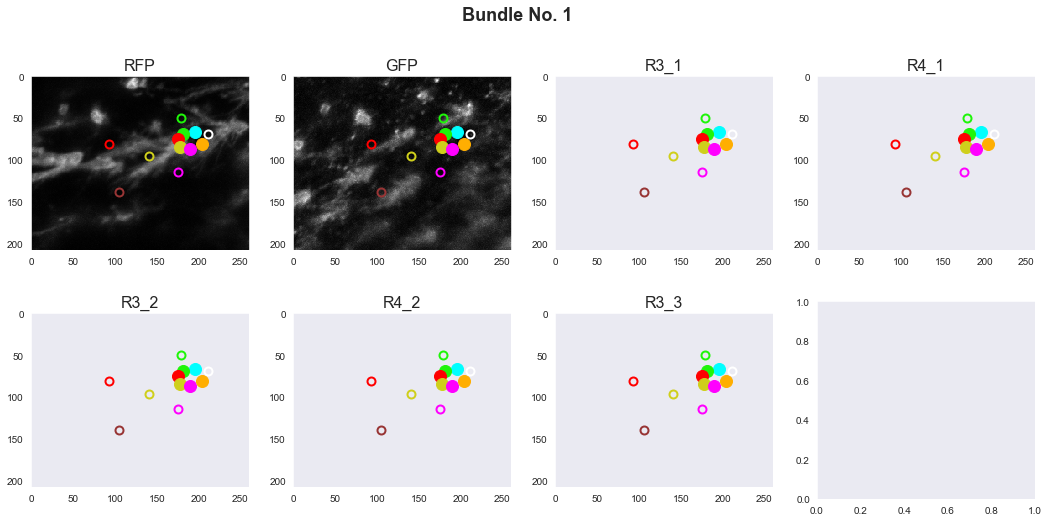

63


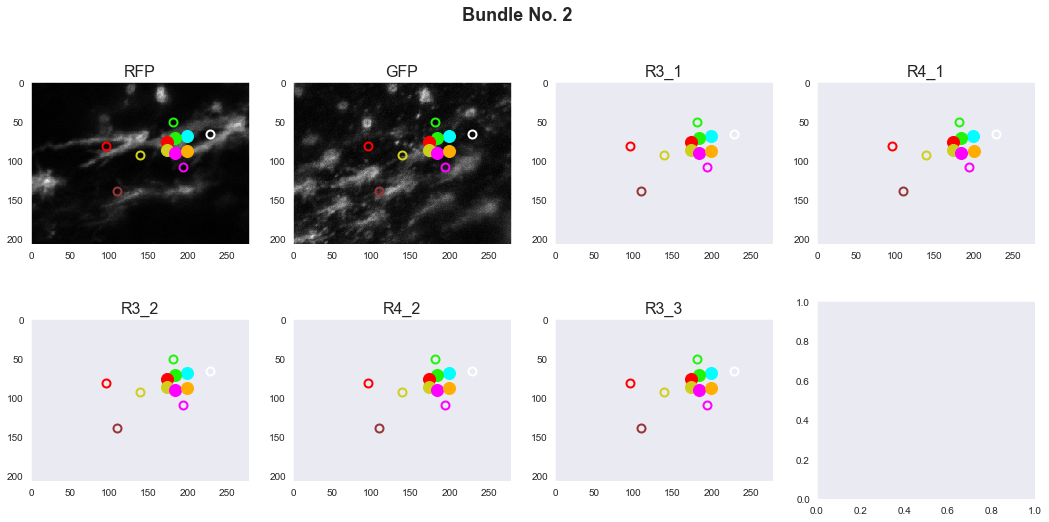

73


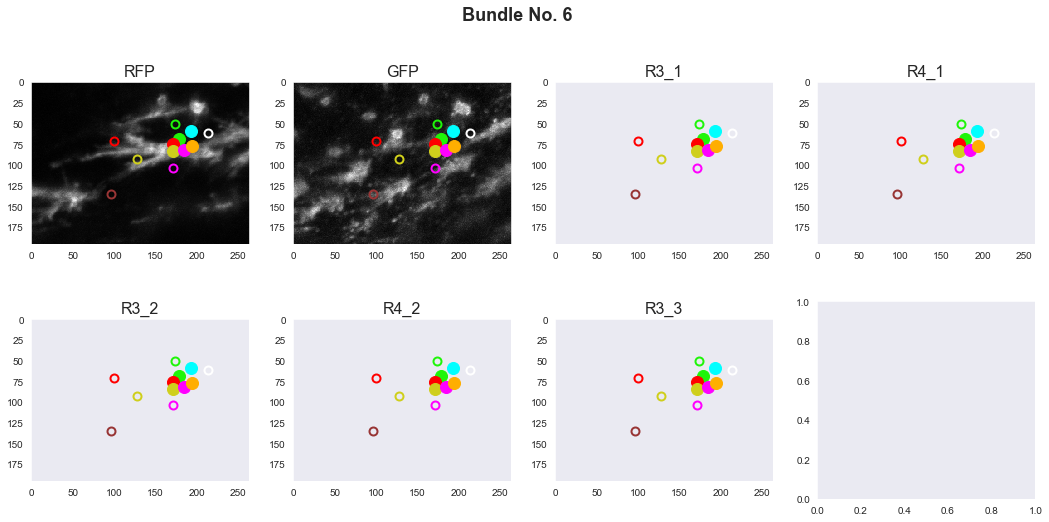

64


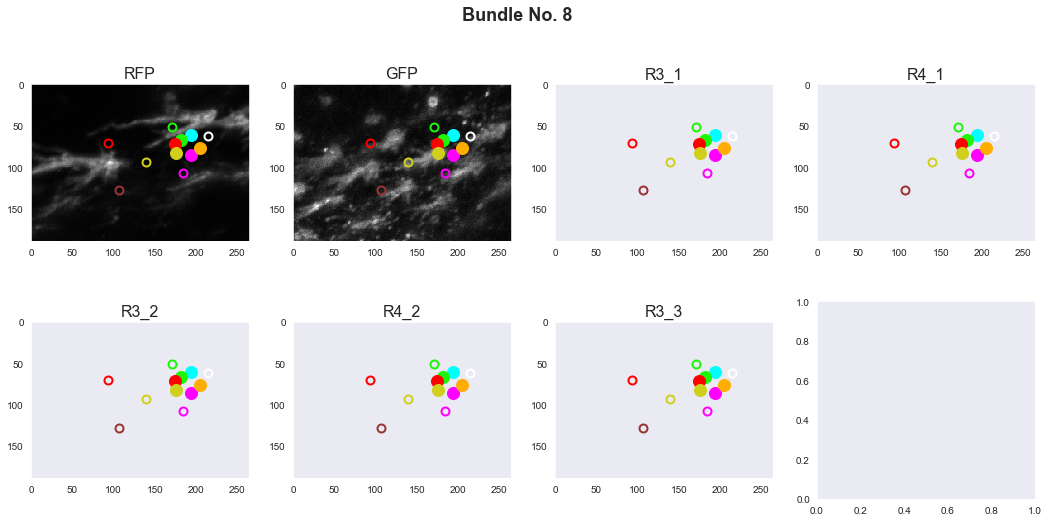

62


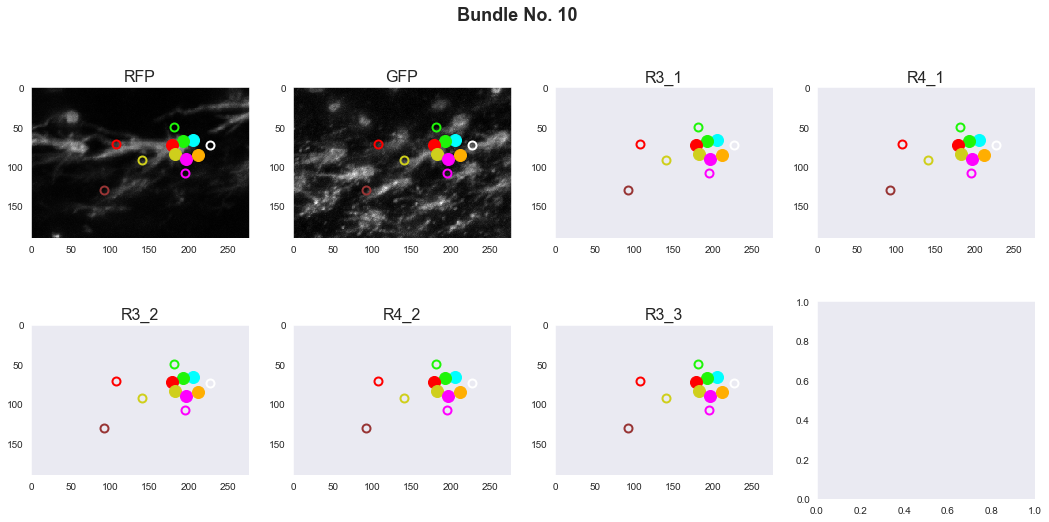

65


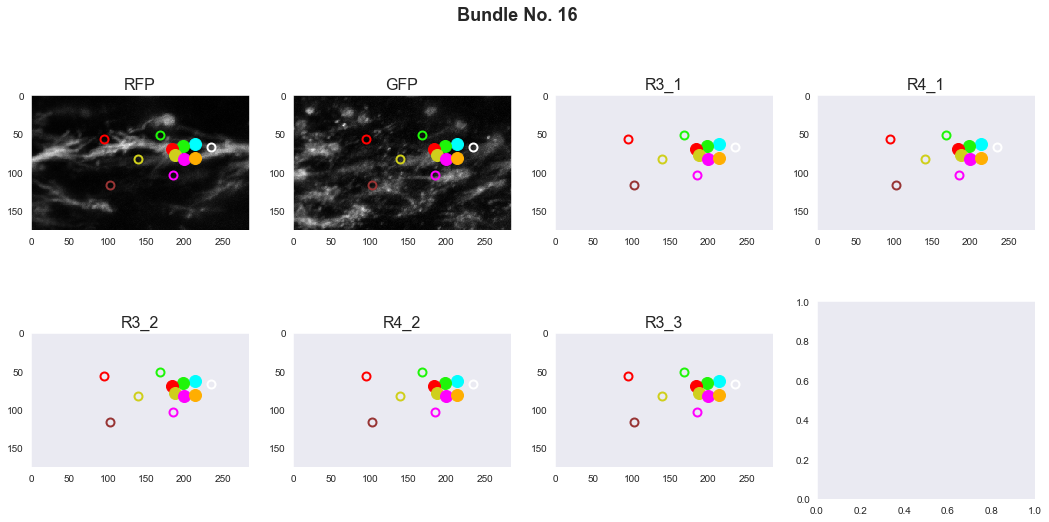

65


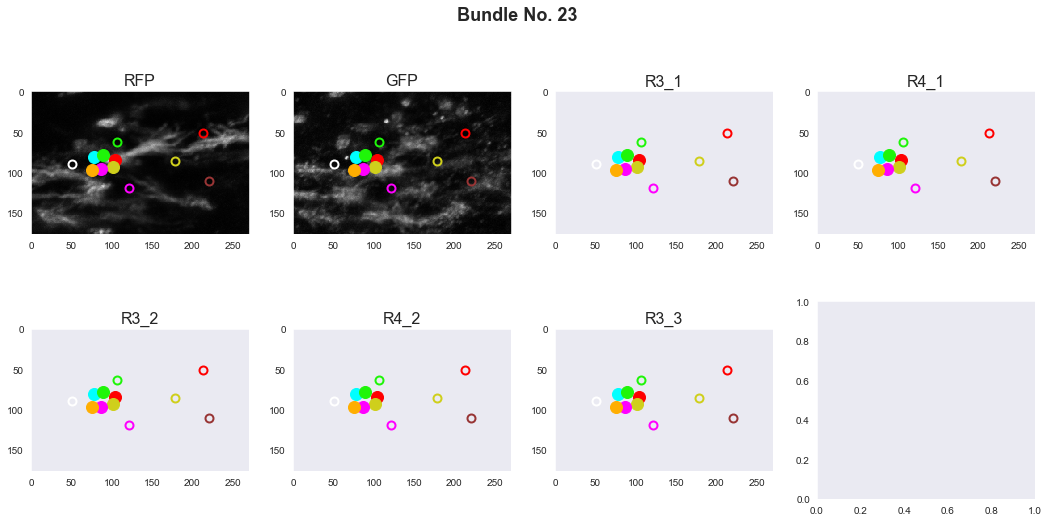

70


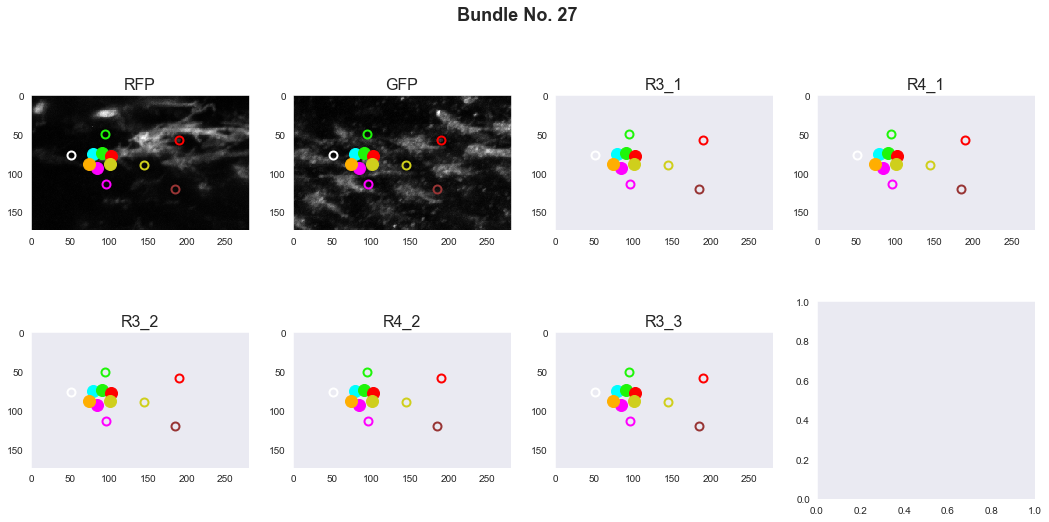

36


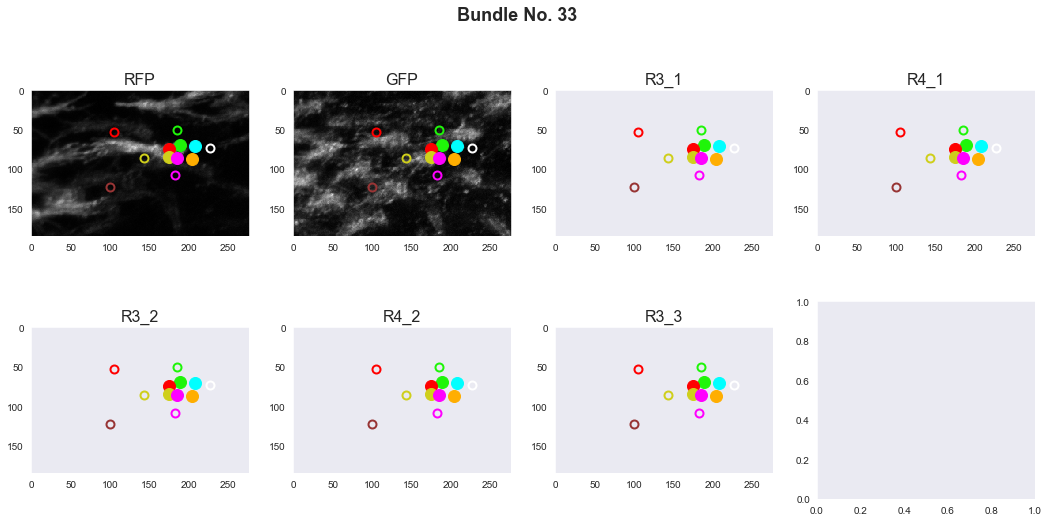

41


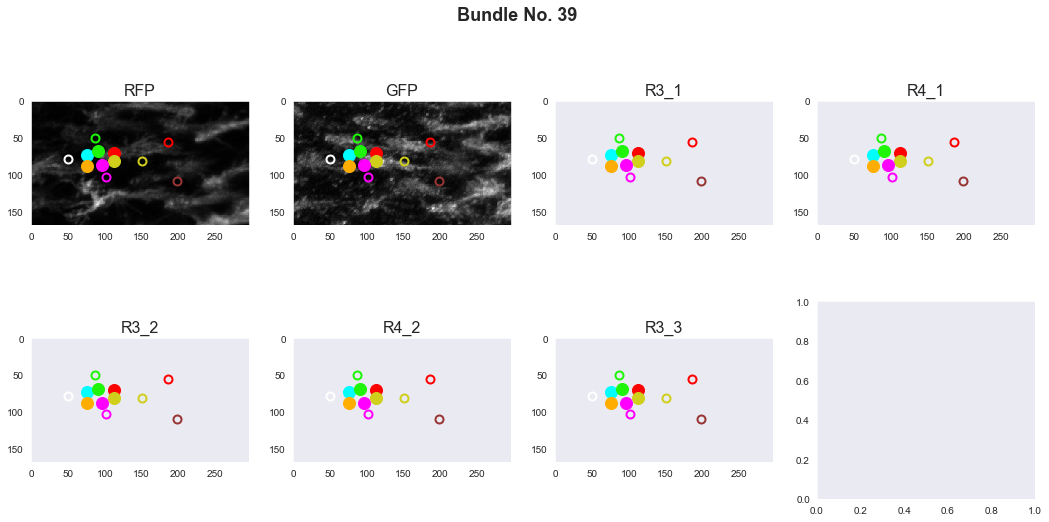

41


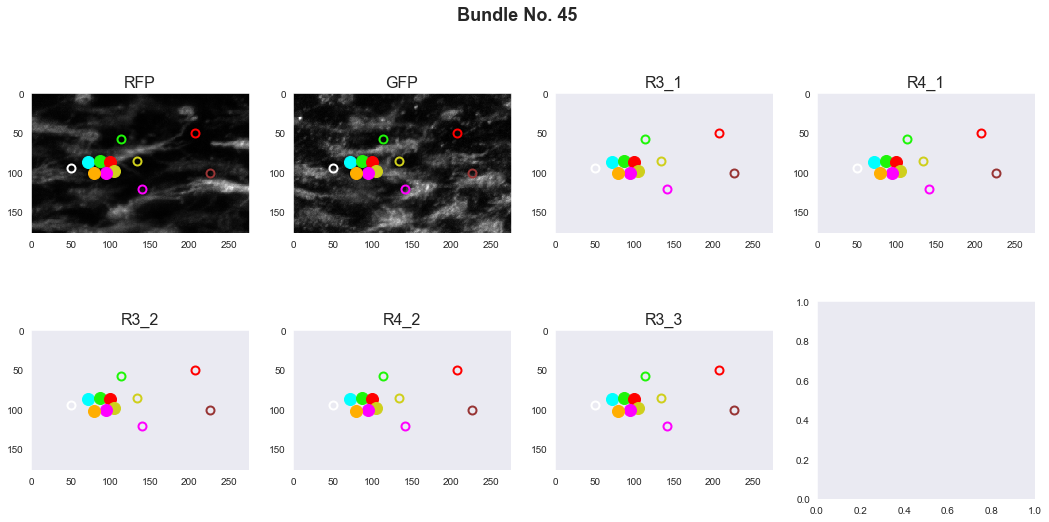

In [164]:
for ind in range(len(annot_bundles_df.index)):
# ind = 12
    bundle_No = list(annot_bundles_df.index)[ind]
    plotSettings = False, False, False, True #isPlotR3Line, isPlotR4Line, isPlotR4s, isLabelOff
    # image_norm[:,:,:,2] = filter_test_rfp[:,:,:,2]
    # image_norm[:,:,:,3] = filter_test_gfp[:,:,:,2]
    # my_plot.plotIndividualBundles(bundle_No, bundles_df, image_norm[:,:,:,0:6], M2P_ratio[0], M2P_ratio[1], z_offset, plotSettings, matching_info)
    my_plot.plotIndividualBundles(bundle_No, bundles_df, image_norm, M2P_ratio[0], M2P_ratio[1], z_offset, plotSettings, matching_info)
    plt.show()

In [60]:
annot_bundles_df.iloc[0]['CategoryID']

'Fz'

In [ ]:
from guppy import hpy

In [76]:
""" get intensity matrix for good bundles"""

' get intensity matrix for good bundles'

In [77]:
### initialization
print('-----' + image_list[i_image] + '------')
matrixY = num_angleSection + 2*num_outsideAngle + 1
matrixX = num_Xsection + 1
matrixZ = z_offset * 2 + 1
# num_norm_channels = len(channel_cmap.keys())
num_norm_channels = 2

IntensityMatrix = np.zeros((len(annot_bundles_df.index), num_norm_channels, matrixY, matrixX, matrixZ))
#IntensityMatrix.shape = ind, slicetype, centertype, channelNo, matrixX, matrixY, matrixZ
IntensityMatrix = IntensityMatrix - 100
params = []; #params.shape = ind, slicetype, centertype

rel_points = np.zeros((len(annot_bundles_df.index), 9))
#params.shape = ind, slicetype, centertype

-----Fz_Gal80_smp24_region1.tif------


In [81]:
annot_bundles_df.index

Int64Index([1, 7, 8, 9, 10, 14, 21, 22, 27, 33, 40, 41, 43, 48, 49], dtype='int64', name='Bundle_No')

In [86]:
### parse bundles
# for ind in range(len(annot_bundles_df.index)):
for ind in [5]:
    bundle_No = list(annot_bundles_df.index)[ind]
    R_Z = int(bundles_df.loc[bundle_No,'coord_Z_R' + str(3)]) - 1
    print("Bundle No: ", bundle_No)

    ### targets info
    indTs, coordTs = my_help.getTargetCoords(bundle_No, bundles_df, targetIndexMatch)
    coord_Center = my_help.getBundleCenter(bundle_No, bundles_df)
    coordR4s = my_help.getRxCoords(bundle_No, bundles_df, indTs, 4)
    coordR3s = my_help.getRxCoords(bundle_No, bundles_df, indTs, 3)
    coordRs = np.concatenate((coordR4s, coordR3s))

    ### slice info
    SliceZeroPoint = coordTs[targetIndexMatch_rev[7],:] # T3'
    SliceOnePoint = coordTs[targetIndexMatch_rev[3],:] # T3

    ## slice radius info
    LengthOnePoint = coordTs[targetIndexMatch_rev[4],:]

    CenterPoints = [coordTs[0,:], coord_Center[0,:]]

    Rcell_nums = [4,4]

    printingParams = [False, False]

    ### get slicing params, calculate matrix
    centertype = 1
    slicetype = 1
    analysis_params = [analysisParams_general[0], analysisParams_general[1], analysisParams_general[2], analysisParams_general[3], analysisParams_general[4][centertype]]
    bundleParams = [bundle_No, indTs, coordTs, coord_Center, SliceZeroPoint, SliceOnePoint, LengthOnePoint, CenterPoints[centertype], Rcell_nums[centertype]]
    if(slicetype == 0):
        pp_i, rel_points_i = my_int.getSliceParams_v1(analysis_params, bundles_df, bundleParams, printingParams, matching_info[4])
    elif(slicetype == 1):
        pp_i, rel_points_i = my_int.getSliceParams_v3(analysis_params, bundles_df, bundleParams, printingParams, matching_info[4])
    params.append(pp_i)
    rel_points[ind, :] = rel_points_i

    for channelNo in range(num_norm_channels):
        print("Channle No: " + str(channelNo))
        %time IntensityMatrix[ind, channelNo,:,:,:] = my_int.getIntensityMatrix_new(pp_i, image_norm, channel_mapping[channelNo], channel_mapping)
        matrix_shape = IntensityMatrix[ind, channelNo,:,:,:].shape
        IntensityMatrix[ind, channelNo,:,:,:] = np.random.randn(matrix_shape[0], matrix_shape[1], matrix_shape[2])
    params.append(pp_i)

Bundle No:  14
Channle No: 0
666 370
(655, 1618)
Error! Too close to the boundary!
666 370
(655, 1618)
Error! Too close to the boundary!
666 370
(655, 1618)
Error! Too close to the boundary!
666 370
(655, 1618)
Error! Too close to the boundary!
666 370
(655, 1618)
Error! Too close to the boundary!
666 370
(655, 1618)
Error! Too close to the boundary!
666 370
(655, 1618)
Error! Too close to the boundary!
666 370
(655, 1618)
Error! Too close to the boundary!
666 370
(655, 1618)
Error! Too close to the boundary!
666 370
(655, 1618)
Error! Too close to the boundary!
666 370
(655, 1618)
Error! Too close to the boundary!
CPU times: user 54.8 ms, sys: 11 ms, total: 65.7 ms
Wall time: 61.2 ms
Channle No: 1
666 370
(655, 1618)
Error! Too close to the boundary!
666 370
(655, 1618)
Error! Too close to the boundary!
666 370
(655, 1618)
Error! Too close to the boundary!
666 370
(655, 1618)
Error! Too close to the boundary!
666 370
(655, 1618)
Error! Too close to the boundary!
666 370
(655, 1618)
Er

In [ ]:
params[0]

In [ ]:
import Data_quantification_function_plotting4 as my_plot

In [ ]:
### plotting
for ind in [0]:
    bundle_No = list(annot_bundles_df.index)[ind]
    R_Z = int(bundles_df.loc[bundle_No,'coord_Z_R' + str(3)]) - 1
    print("Bundle No: ", bundle_No)
    #     DV = bundles_df.loc[bundle_No, 'Orientation_DV']
    #     AP = bundles_df.loc[bundle_No, 'Orientation_AP']

    ### targets info
    indTs, coordTs = my_help.getTargetCoords(bundle_No, bundles_df, targetIndexMatch)
    coord_Center = my_help.getBundleCenter(bundle_No, bundles_df)
    coordR4s = my_help.getRxCoords(bundle_No, bundles_df, indTs, 4)
    coordR3s = my_help.getRxCoords(bundle_No, bundles_df, indTs, 3)
    coordRs = np.concatenate((coordR4s, coordR3s))

    ### plotting heatmap
    for centertype in [0]:
        for slicetype in [0]:
            pp_i = params[ind]
            rel_points_i = rel_points[ind, :]
            
            matrix = my_help.delete_zero_columns(IntensityMatrix[ind, :, :, :, :], -100, 3)
#             matrix = IntensityMatrix[ind, centertype, slicetype, :, :, :, :]
    
            plt.ioff()
            img_name = image_list[i_image]
            ori_X = np.round(np.linspace(0, radiusExpanseRatio[centertype], matrix.shape[2]), 2)
            tickParams = [2, 1, ori_X, 21] ### tickTypeX, tickTypeY, tickArg2_X, tickArg2_Y
            figParams = [centertype, pp_i, figOutPrefix, img_name, slicetype, radiusExpanseRatio[centertype]]
            for thrFunction in [0]: # different thresholding methods
                if(thrFunction == 0):
                    thrs = np.zeros((7))
                elif(thrFunction == 1):
                    thrs = thr_otsu
                #     elif(thrFunction == 2):
                #         thrs = thr_li
                plotOptions = [True, True, True, True, False, thrs, thrFunction, num_norm_channels] ### isPlotLine, isLabelOff, isSave, isTrueXTick, isOriTick, thrFunction            
                fig = my_plot.plotBundleVsMatrix_all(bundle_No, bundles_df, image_norm, matrix, figParams, tickParams, plotOptions, matching_info)
                #                 plt.close(fig)
                plt.show()
                
            ## plotting: polar
#             figParams = pp_i, figOutPrefix, img_name, radiusExpanseRatio[centertype], centertype, slicetype
#             plotOptions = [True, False] # isLabelOff, isSave
#             for channelNo in range(num_norm_channels):
#                 analysis_params = [analysisParams[0], analysisParams[1], analysisParams[2], analysisParams[3], analysisParams[4][centertype]]
#                 fig = my_plot.plotPolar(bundle_No, bundles_df, image_norm, analysis_params, channelNo, matrix, figParams, plotOptions, matching_info, rel_points[slicetype, centertype, ind, :])
#         #         plt.close(fig)
#                 plt.show()

In [ ]:
import Data_quantification_function_plotting11 as my_plot

In [ ]:
### Save matrixes and parameters

In [ ]:
categoryID = annot_bundles_df.iloc[0]['CategoryID']
sampleID = annot_bundles_df.iloc[0]['SampleID']
regionID = annot_bundles_df.iloc[0]['RegionID']

In [ ]:
outputData = {
    'categoryID' : categoryID,
    'sampleID' : sampleID,
    'regionID':regionID,
    'sliceType':slicetype,
    'centerType':centertype,
    'intensityMatrix':IntensityMatrix,
    'parameter':params,
    'relativePositions':rel_points
}

In [ ]:
now = datetime.datetime.now()
date_info = str(now.year)+str(now.month)+str(now.day)+str(now.hour)+str(now.minute)
outputname = f'{categoryID}_sample{sampleID}_region{regionID}_slice{slicetype}_center{centertype}_v{date_info}.pickle'

In [ ]:
outputDir = os.path.join(dataOutPrefix)
my_help.check_dir(outputDir)
outputDir = os.path.join(outputDir,categoryID)
my_help.check_dir(outputDir)
# outputname = categoryID + '_sample' + str(sampleID) + '_region' + str(regionID) +  + '.pickle'
outputname = os.path.join(outputDir, outputname)
pickle_out = open(outputname,"wb")
pickle.dump(outputData, pickle_out)
pickle_out.close()